MCMC‑NF: 100%|██████████| 50000/50000 [16:01<00:00, 51.99it/s, loss=3177510.000]



=== Adult Income — Bayesian LogReg ===
Acceptance rate  : 64.2%
ESS (avg)        : 29
Test accuracy    : 0.854
Test log‑loss    : 0.319



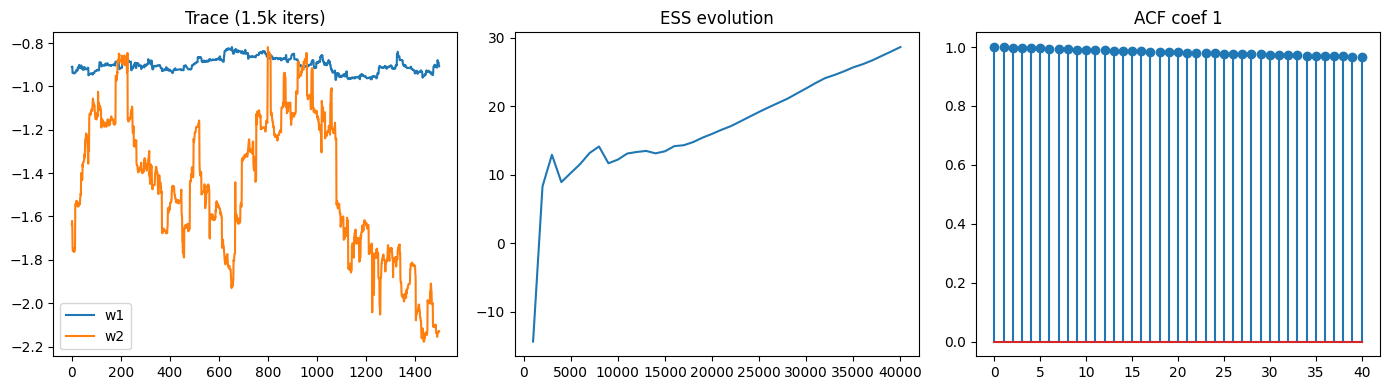

In [6]:
"""
Bayesian Logistic Regression on UCI Adult Income
MCMC with Normalizing‑Flow Proposals
"""
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal
from statsmodels.tsa.stattools import acf as sm_acf
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt


# Data loader & preprocessing

def load_adult():
    adult = fetch_openml("adult", version=2, as_frame=True)
    df = adult.frame
    y = (df["class"] == ">50K").astype(np.float32).values
    X = df.drop(columns=["class"])
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    pre = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ])
    X_proc = pre.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_proc, y, test_size=0.2, random_state=42, stratify=y
    )
    to_tensor = lambda m: torch.tensor(m.toarray() if hasattr(m, "toarray") else m).float()
    return to_tensor(X_train), torch.tensor(y_train).float(), to_tensor(X_test), torch.tensor(y_test).float()


# Posterior: Bayesian logistic regression

class LogisticPosterior:
    def __init__(self, X, y, prior_scale: float = 2.0):
        self.X, self.y = X, y
        self.N, self.d = X.shape
        self.prior_scale = prior_scale

    def log_prob(self, w: torch.Tensor):
        if w.ndim == 1:
            w = w.unsqueeze(0)
        logits = self.X @ w.T
        ll = -torch.nn.functional.binary_cross_entropy_with_logits(
            logits, self.y.unsqueeze(1).expand(-1, w.size(0)), reduction="sum"
        )
        log_prior = -0.5 * torch.sum(w ** 2, dim=1) / self.prior_scale ** 2
        return ll + log_prior


# RealNVP flow
class RealNVP(nn.Module):
    def __init__(self, dim, hidden=256, flows=20):
        super().__init__()
        self.masks = [torch.from_numpy(((np.arange(dim) + i) % 2).astype(np.float32))
                      for i in range(flows)]
        self.s_nets = nn.ModuleList([self._mlp(dim, hidden) for _ in range(flows)])
        self.t_nets = nn.ModuleList([self._mlp(dim, hidden) for _ in range(flows)])

    @staticmethod
    def _mlp(d, h):
        return nn.Sequential(
            nn.Linear(d, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, d)
        )


    def forward(self, z):
        log_det = torch.zeros(z.size(0), device=z.device)
        x = z
        for m, s_net, t_net in zip(self.masks, self.s_nets, self.t_nets):
            m = m.to(z.device)
            z_m = x * m
            s = s_net(z_m) * (1 - m)
            t = t_net(z_m) * (1 - m)
            x = z_m + (1 - m) * (x * torch.exp(s) + t)
            log_det += torch.sum(s, dim=1)
        return x, log_det


# ESS
def ess(samples: np.ndarray):
    n, d = samples.shape
    es = []
    for j in range(d):
        rho = sm_acf(samples[:, j], nlags=min(1000, n // 2), fft=True)
        tau = 1 + 2 * np.sum(rho[1:])
        es.append(n / tau)
    return float(np.mean(es))


# MCMC‑NF
def run_mcmc_adult(n_samples=40000, burn_in=10000, lr=2e-4, block_frac=0.15, step=0.1, device="cpu"):
    X_tr, y_tr, X_te, y_te = load_adult()
    d = X_tr.shape[1]
    target = LogisticPosterior(X_tr.to(device), y_tr.to(device))

    flow = RealNVP(d).to(device)
    opt = optim.Adam(flow.parameters(), lr=lr)
    base = MultivariateNormal(torch.zeros(d, device=device), torch.eye(d, device=device))

    total = n_samples + burn_in
    k = max(1, int(block_frac * d))
    samples = np.empty((n_samples, d), dtype=np.float32)
    trace12, ess_evol = [], []
    accept = 0

    z = base.sample()
    x, logdet = flow(z.unsqueeze(0))
    lp = target.log_prob(x.squeeze(0)) + logdet.squeeze(0)

    pbar = tqdm(range(total), desc="MCMC‑NF")
    for t in pbar:
        z_prop = z.clone()
        idx = torch.randperm(d, device=device)[:k]
        z_prop[idx] += torch.randn(k, device=device) * step
        x_prop, ld_prop = flow(z_prop.unsqueeze(0))
        lp_prop = target.log_prob(x_prop.squeeze(0)) + ld_prop.squeeze(0)
        if torch.rand(1).log().item() < (lp_prop - lp).item():
            z, x, lp = z_prop, x_prop.squeeze(0), lp_prop
            accept += 1

        if t >= burn_in:
            s_idx = t - burn_in
            samples[s_idx] = x.detach().cpu().numpy()
            if s_idx < 1500:
                trace12.append(x[:2].detach().cpu().numpy())
            if (s_idx + 1) % 1000 == 0:
                ess_evol.append(ess(samples[: s_idx + 1]))

        if t < burn_in and t % 100 == 0:
            opt.zero_grad()
            zb = base.sample((256,))
            xb, ldb = flow(zb)
            loss = torch.mean(base.log_prob(zb) - (target.log_prob(xb) + ldb))
            loss.backward()
            opt.step()
            pbar.set_postfix(loss=f"{loss.item():.3f}")

    acc_rate = accept / total
    ess_val = ess(samples)

    w_mean = torch.tensor(samples.mean(0)).to(device)
    with torch.no_grad():
        logits_te = X_te.to(device) @ w_mean
        probs = torch.sigmoid(logits_te)
        y_pred = (probs > 0.5).float()
        acc_te = (y_pred == y_te.to(device)).float().mean().item()
        logloss_te = torch.nn.functional.binary_cross_entropy_with_logits(logits_te, y_te.to(device), reduction="mean").item()

    # plots
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    trace = np.array(trace12)
    axs[0].plot(trace[:, 0], label="w1")
    axs[0].plot(trace[:, 1], label="w2")
    axs[0].set_title("Trace (1.5k iters)")
    axs[0].legend()

    axs[1].plot(np.arange(1000, n_samples + 1, 1000), ess_evol)
    axs[1].set_title("ESS evolution")

    acorr = sm_acf(samples[:, 0], nlags=40, fft=True)
    axs[2].stem(range(len(acorr)), acorr)
    axs[2].set_title("ACF coef 1")

    plt.tight_layout()
    plt.savefig("diagnostics.png", dpi=150)

    print("\n=== Adult Income — Bayesian LogReg ===")
    print(f"Acceptance rate  : {acc_rate:.1%}")
    print(f"ESS (avg)        : {ess_val:.0f}")
    print(f"Test accuracy    : {acc_te:.3f}")
    print(f"Test log‑loss    : {logloss_te:.3f}\n")

    return dict(samples=samples, ess=ess_val, acc_rate=acc_rate, acc_test=acc_te, logloss_test=logloss_te)

# --------------------------------------------------


device = "cuda" if torch.cuda.is_available() else "cpu"
run_mcmc_adult(device=device)
